In [1]:
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dem_ds = gdal.Open("data/digital_elevation_model.tif", gdal.GA_ReadOnly)
print("Basic metadata")
print("Bands count: %s" % dem_ds.RasterCount)
print("Rows: %s | Cols: %s" % (dem_ds.RasterYSize, dem_ds.RasterXSize))
print("GeoTransform: %s" % str(dem_ds.GetGeoTransform()))
print("Coordinate reference system: %s" % dem_ds.GetProjection())

Basic metadata
Bands count: 1
Rows: 632 | Cols: 616
GeoTransform: (18.70875, 0.0002777777775974056, 0.0, 43.559861111, 0.0, -0.00027777777689872693)
Coordinate reference system: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


In [3]:
# Растр целиком
dem_ds_data = dem_ds.ReadAsArray()

# Данные конкретного канала
dem_ds_band1 = dem_ds.GetRasterBand(1)
dem_ds_band1_data = dem_ds_band1.ReadAsArray()

print(dem_ds_data.shape)
print(dem_ds_band1_data.shape)

(632, 616)
(632, 616)


In [4]:
# значение высоты в ячейке 50, 50
print(dem_ds_data[50, 50])

# срез высот
print(dem_ds_data[40:48, 40:48])


754
[[752 762 773 783 792 799 806 813]
 [747 757 767 777 785 792 799 809]
 [746 754 763 772 780 789 796 803]
 [741 750 759 769 779 787 794 799]
 [736 745 753 763 773 780 786 790]
 [727 738 747 755 762 770 777 781]
 [720 731 741 747 753 761 769 775]
 [713 725 735 741 746 753 761 768]]


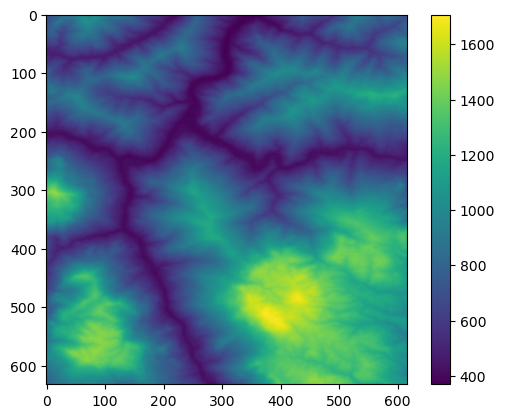

In [5]:
# визуализация целиком
plt.imshow(dem_ds_data)
plt.colorbar()
plt.show()

In [6]:
# вычисление координат конкретной ячейки (50;50) на основе GeoTransform
geotransform = dem_ds.GetGeoTransform()
origin_x = geotransform[0]
origin_y = geotransform[3]
pixel_size_x = geotransform[1]
pixel_size_y = geotransform[5]

x_coord = origin_x + 50 * pixel_size_x
y_coord = origin_y + 50 * pixel_size_y

print(x_coord, y_coord)

18.722638888879867 43.54597222215506


In [7]:
# средняя высота всего участка территории
print(dem_ds_data.mean())

# маска для ячеек со значением > 1500
high_elevations = dem_ds_data[dem_ds_data > 1500]
print(high_elevations.shape[0])

867.7228289906296
8111


In [8]:
imagery_ds = gdal.Open("data/multiband_imagery.tif", gdal.GA_ReadOnly)
print("Bands count: %s" % imagery_ds.RasterCount)

imagery_ds_data = imagery_ds.ReadAsArray()
print(imagery_ds_data.shape)

Bands count: 4
(4, 177, 191)


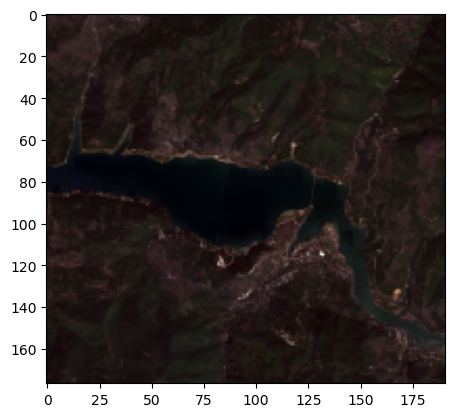

In [9]:
# описываем функцию, которая будет нормализовать значения канала в диапазон от 0 до 1
def normalize(input_band):
    min_value, max_value = input_band.min() * 1.0, input_band.max() * 1.0
    return (input_band * 1.0 - min_value * 1.0) / (max_value * 1.0 - min_value)


rgb_normalized = np.dstack(
    [
        normalize(imagery_ds_data[2]),
        normalize(imagery_ds_data[1]),
        normalize(imagery_ds_data[0]),
    ]
)

plt.imshow(rgb_normalized)
plt.show()

/tmp/ipykernel_369949/606193499.py:4: RuntimeWarning: divide by zero encountered in divide
  ndvi = (nir_band - red_band) / (nir_band + red_band)


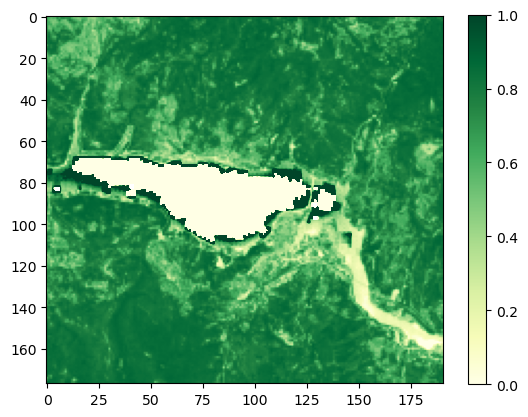

In [10]:
# Вычисляем NDVI
red_band = imagery_ds_data[2]  # Красный канал
nir_band = imagery_ds_data[3]  # Ближний инфракрасный канал
ndvi = (nir_band - red_band) / (nir_band + red_band)

# применяем жёлто-зелёную шкалу от 0 до 1. Чем зеленее, тем больше NDVI
plt.imshow(ndvi, cmap="YlGn", vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [11]:
# данные из архива (vsizip)
ds_from_zip = gdal.Open("/vsizip/data/land_cover_types.zip/land_cover_types.tif")
ds_from_zip_data = ds_from_zip.ReadAsArray()
print("Срез данных в растре из архива:")
print(ds_from_zip_data[100:105, 100:105])

# данные из сетевого хранилища (vsicurl)
ds_from_url = gdal.Open("/vsicurl/https://demo.nextgis.com/api/resource/7220/cog")
print("\nРазмер сетевого растра:")
print(ds_from_url.RasterXSize)
print(ds_from_url.RasterYSize)

# Читаем конкретные значения, не скачивая весь растр
print("4 пикселя начиная с адреса 10000, 10000. Все каналы:")
print(ds_from_url.ReadAsArray(10000, 10000, 2, 2))

Срез данных в растре из архива:
[[20 20 20 25 25]
 [20 20 20 20 25]
 [20 25 25 25 20]
 [20 20 20 20 20]
 [10 10 10 10 20]]

Размер сетевого растра:
28416
24320
4 пикселя начиная с адреса 10000, 10000. Все каналы:
[[[101  99]
  [ 99  97]]

 [[ 98  96]
  [ 98  96]]

 [[ 93  91]
  [ 94  92]]

 [[255 255]
  [255 255]]]


In [12]:
# возвращаемся к набору dem_ds и перепроецируем его
dem_ds_transformed = gdal.Warp("", dem_ds, format="MEM", dstSRS="EPSG:32634")

# И всё готово, в переменной dem_ds_transformed хранящийся в памяти gdal.Dataset готовый к работе
# читаем и смотрим на GeoTransform
geotransform = dem_ds_transformed.GetGeoTransform()
print("Новый GeoTransform:")
print(geotransform)

# читаем перепроецированную матрицу значений и применяем маску
dem_ds_transformed_data = dem_ds_transformed.ReadAsArray()
high_elevations = dem_ds_transformed_data[dem_ds_transformed_data > 1500]

pixel_size_x = abs(geotransform[1])
pixel_size_y = abs(geotransform[5])
total_area = high_elevations.shape[0] * (pixel_size_x * pixel_size_y) / 1000000
print("Общая площадь районов с высотой > 1500 м: %s км2" % round(total_area, 3))

del dem_ds_transformed

Новый GeoTransform:
(314409.25304288446, 27.10218162365495, 0.0, 4825539.987535062, 0.0, -27.10218162365495)
Общая площадь районов с высотой > 1500 м: 5.626 км2


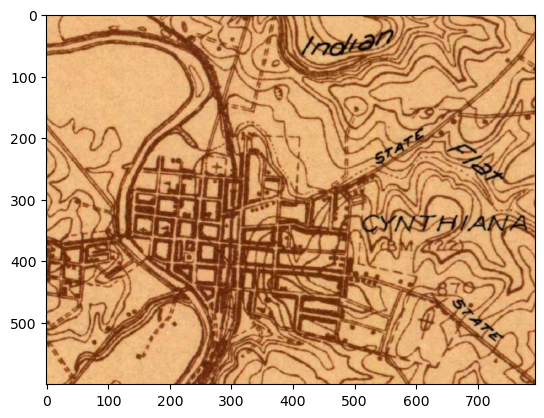

In [13]:
# Посмотрим на исходные данные как на RGB картинку
import matplotlib.image as mpimg

image = mpimg.imread("data/topomap.tif")
plt.imshow(image)
plt.show()

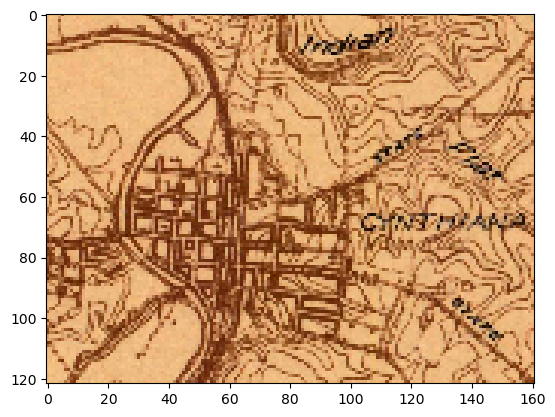

In [14]:
# отправим их в gdal.Translate с двумя заданиями - конвертация формата и загрубление пространственного разрешения
topomap_converted = gdal.Translate(
    "data/topomap_converted.png",
    "data/topomap.tif",
    format="PNG",
    xRes=20,
    yRes=20,
    creationOptions=["WORLDFILE=YES"],
)
del topomap_converted

# Смотрим на новый растр
image = mpimg.imread("data/topomap_converted.png")
plt.imshow(image)
plt.show()

In [15]:
# открываем данные и считаем NDVI
imagery_ds = gdal.Open("data/multiband_imagery.tif", gdal.GA_ReadOnly)
imagery_ds_data = imagery_ds.ReadAsArray()
red_band = imagery_ds_data[2]  # Красный канал
nir_band = imagery_ds_data[3]  # Ближний инфракрасный канал
ndvi = (nir_band - red_band) / (nir_band + red_band)

# записываем матрицу в новый файл
# Выбираем драйвер (формат выходного файла)
driver = gdal.GetDriverByName("GTiff")

# У нас будет 1 канал, только NDVI
band_count = 1

# Выбираем тип данных
data_type = gdal.GDT_Float32

# Создаём файл на основе выбранного драйвера, наследуя размер у исходного набора
dataset = driver.Create(
    "data/ndvi.tif",
    imagery_ds.RasterXSize,
    imagery_ds.RasterYSize,
    band_count,
    data_type,
)

# Заимствуем GeoTransform и систему координат у исходного растра (новый такой же, т.к. произведен в его пространственном домене)
dataset.SetProjection(imagery_ds.GetProjection())
dataset.SetGeoTransform(imagery_ds.GetGeoTransform())

# Записываем сами данные
dataset.GetRasterBand(1).WriteArray(ndvi)

del dataset

/tmp/ipykernel_369949/1689867793.py:6: RuntimeWarning: divide by zero encountered in divide
  ndvi = (nir_band - red_band) / (nir_band + red_band)
